In [80]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [7]:
import pandas as pd
import geopandas as gpd

# Read the meta-data file
meta_data = pd.read_csv('/data/attributes.csv')

# Read the location data
location_data = gpd.read_file('/data/locations.geojson')

# Concatenate all the measurements files into a single data frame

years = ['2016', '2017', '2018']
measurements_data = pd.concat([pd.read_csv(f'/data/measurements-{y}.csv') for y in years])
print(measurements_data)

                       date   BEN    CO   EBE   MXY  NMHC        NO_2  \
0       2016-06-01 01:00:00   NaN  0.47   NaN   NaN   NaN   83.089996   
1       2016-06-01 01:00:00   NaN  0.59   NaN   NaN   NaN   94.820000   
2       2016-06-01 01:00:00   NaN  0.55   NaN   NaN   NaN   75.919998   
3       2016-06-01 01:00:00   NaN  0.36   NaN   NaN   NaN   61.029999   
4       2016-06-01 01:00:00  1.68  0.80  1.70  3.01  0.30  105.199997   
...                     ...   ...   ...   ...   ...   ...         ...   
209443  2018-08-01 00:00:00   NaN  0.55   NaN   NaN   NaN  125.000000   
209444  2018-08-01 00:00:00   NaN  0.27   NaN   NaN   NaN   45.709999   
209445  2018-08-01 00:00:00   NaN   NaN   NaN   NaN  0.24   46.560001   
209446  2018-08-01 00:00:00   NaN   NaN   NaN   NaN   NaN   46.770000   
209447  2018-08-01 00:00:00  0.92  0.43  0.71   NaN  0.25   76.330002   

               NOx   OXY        O_3       PM10       PM25   PXY   SO_2   TCH  \
0       120.699997   NaN  16.990000  16.889

In [128]:
from geopy.distance import geodesic
import json

# Load the GeoJSON file
with open('locations.geojson') as f:
    data = json.load(f)

# Define the target location
target_lat = 40.4279425
target_lon = -3.6907764

# Calculate the distance between the target location and each station location
distances = []
for feature in data['features']:
    lon, lat = feature['geometry']['coordinates']
    distance = geodesic((lat, lon), (target_lat, target_lon)).km
    distances.append(distance)

# Find the index of the closest station
index_of_closest_station = distances.index(min(distances))

# Get the properties of the closest station
closest_station_properties = data['features'][index_of_closest_station]['properties']
closest_station_properties
distances.sort()
print(distances)
print('closest station data', closest_station_properties)


[1.0083394183055994, 1.3279431895324176, 1.4308232536370589, 1.6522875866868805, 1.8777774906056952, 2.3969052281782623, 2.8504351054723274, 3.329182371077942, 4.181993187908794, 4.452295048330986, 4.575364615837233, 4.89459035064597, 5.07108192107933, 5.329710645303265, 5.533915509873251, 5.855086875267993, 7.793525632000242, 8.067373756308088, 8.075036295977817, 9.050026828948969, 9.174546521226763, 10.093785705615957, 10.855458005913574, 12.275119018098472]
closest station data {'id': 28079008, 'lon': -3.68231944444444, 'lat': 40.4215638888889}


In [9]:
# location_data=location_data.drop(['geometry'], axis=1)
location_data

,id,lon,lat,geometry
0,28079004,-3.712247,40.423853,POINT (-3.71225 40.42385)
1,28079008,-3.682319,40.421564,POINT (-3.68232 40.42156)
2,28079011,-3.677356,40.451475,POINT (-3.67736 40.45148)
3,28079016,-3.639233,40.440047,POINT (-3.63923 40.44005)
4,28079017,-3.713322,40.347139,POINT (-3.71332 40.34714)
5,28079018,-3.731853,40.394781,POINT (-3.73185 40.39478)
6,28079024,-3.747347,40.419356,POINT (-3.74735 40.41936)
7,28079027,-3.580031,40.476928,POINT (-3.58003 40.47693)
8,28079035,-3.703172,40.419208,POINT (-3.70317 40.41921)
9,28079036,-3.645306,40.407947,POINT (-3.64531 40.40795)


In [10]:
filtered_measurement_data= measurements_data[measurements_data['station']==28079008][['date', 'CO']] 
filtered_measurement_data['date']= pd.to_datetime(filtered_measurement_data['date'], format="%Y-%m-%d %H:%M:%S")
filtered_measurement_data.sort_values(by='date', inplace=True)
filtered_measurement_data

,date,CO
94206,2016-01-01 01:00:00,1.62
94232,2016-01-01 02:00:00,1.23
94258,2016-01-01 03:00:00,0.74
94284,2016-01-01 04:00:00,0.76
94310,2016-01-01 05:00:00,0.71
...,...,...
85750,2018-12-31 20:00:00,0.52
85775,2018-12-31 21:00:00,0.65
85800,2018-12-31 22:00:00,0.63
85825,2018-12-31 23:00:00,0.62


<Axes: >

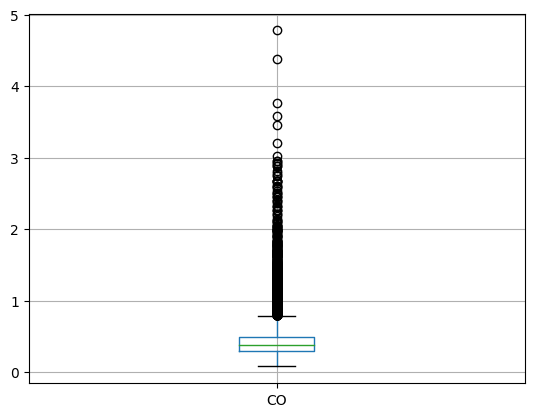

In [11]:
filtered_measurement_data.boxplot(column='CO')

In [ ]:
pd.set_option("display.max_rows", None)
print(filtered_measurement_data[filtered_measurement_data['CO']>1.0])

<Axes: >

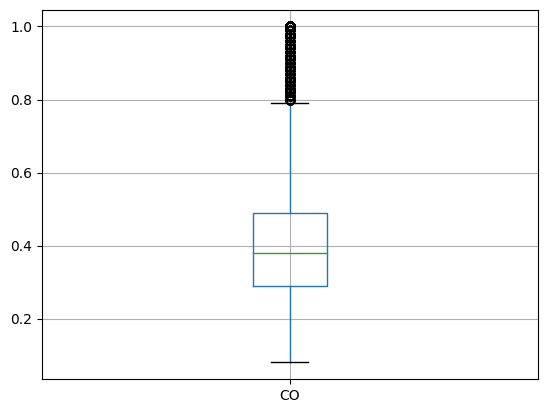

In [12]:
#setting concentration gerater than 1 to 1
filtered_measurement_data.loc[filtered_measurement_data['CO']>1.0, 'CO'] = 1.0
filtered_measurement_data.boxplot(column='CO')

In [13]:
print(filtered_measurement_data[filtered_measurement_data['CO'].isna()])
#It seems nan values are on specific days. This may be due to some machine logging problem. drop nan values 
filtered_measurement_data.dropna(inplace=True)
filtered_measurement_data.count()

                      date  CO
98860  2016-01-08 12:00:00 NaN
98886  2016-01-08 13:00:00 NaN
98912  2016-01-08 14:00:00 NaN
102136 2016-01-13 18:00:00 NaN
102162 2016-01-13 19:00:00 NaN
...                    ...  ..
173150 2018-11-29 12:00:00 NaN
173175 2018-11-29 13:00:00 NaN
173200 2018-11-29 14:00:00 NaN
67649  2018-12-01 15:00:00 NaN
68174  2018-12-02 12:00:00 NaN

[140 rows x 2 columns]


date    26092
CO      26092
dtype: int64

In [79]:
pd.reset_option('display.max_rows')
filtered_measurement_data

,date,CO
94206,2016-01-01 01:00:00,1.00
94232,2016-01-01 02:00:00,1.00
94258,2016-01-01 03:00:00,0.74
94284,2016-01-01 04:00:00,0.76
94310,2016-01-01 05:00:00,0.71
...,...,...
85750,2018-12-31 20:00:00,0.52
85775,2018-12-31 21:00:00,0.65
85800,2018-12-31 22:00:00,0.63
85825,2018-12-31 23:00:00,0.62


In [16]:
import plotly.express as px
import plotly.graph_objects as go
fig = go.Figure()
filtered_data= filtered_measurement_data.set_index('date')
fig.add_trace(go.Scatter(x=filtered_data.loc['2016-01-01 01:00:00' :'2016-06-30 23:00:00'].index, y=filtered_data.loc['2016-01-01 01:00:00' :'2016-06-30 23:00:00', 'CO'], mode='lines'))
fig.add_trace(go.Scatter(x=filtered_data.loc['2017-01-01 01:00:00' :'2017-06-30 23:00:00'].index - pd.DateOffset(years=1), y=filtered_data.loc['2017-01-01 01:00:00' :'2017-06-30 23:00:00', 'CO'], mode='lines'))
fig.add_trace(go.Scatter(x=filtered_data.loc['2018-01-01 01:00:00' :'2018-06-30 23:00:00'].index - pd.DateOffset(years=2), y=filtered_data.loc['2018-01-01 01:00:00' :'2018-06-30 23:00:00', 'CO'], mode='lines'))

fig.show()

In [130]:
filtered_data_resampled_filled= filtered_data.resample('4H').mean().bfill()
fig = go.Figure()
# fig.add_trace(go.Scatter(x=filtered_data_resampled.loc['2017-01-01 01:00:00' :'2017-06-30 23:00:00'].index - pd.DateOffset(years=1), y=filtered_data_resampled.loc['2017-01-01 01:00:00' :'2017-06-30 23:00:00', 'CO'], mode='lines'))
fig.add_trace(go.Scatter(x=filtered_data_resampled_filled.loc['2017-01-01 01:00:00' :'2017-06-30 23:00:00'].index - pd.DateOffset(years=1), y=filtered_data_resampled_filled.loc['2017-01-01 01:00:00' :'2017-06-30 23:00:00', 'CO'], mode='lines', name='downsampled'))
fig.add_trace(go.Scatter(x=filtered_data.loc['2017-01-01 01:00:00' :'2017-06-30 23:00:00'].index  - pd.DateOffset(years=1), y=filtered_data.loc['2017-01-01 01:00:00' :'2017-06-30 23:00:00', 'CO'], mode='lines', name='original'))
fig.show()


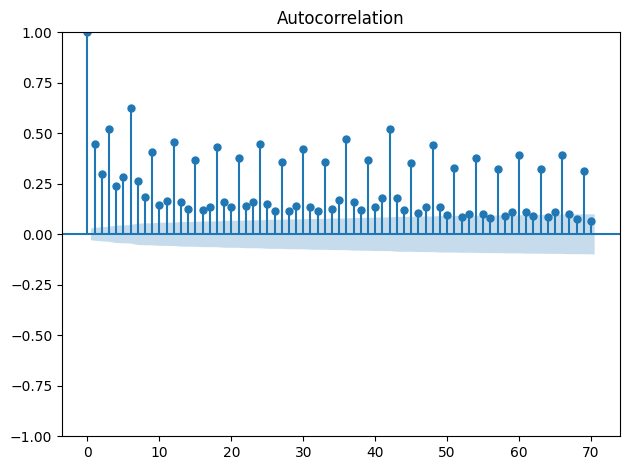

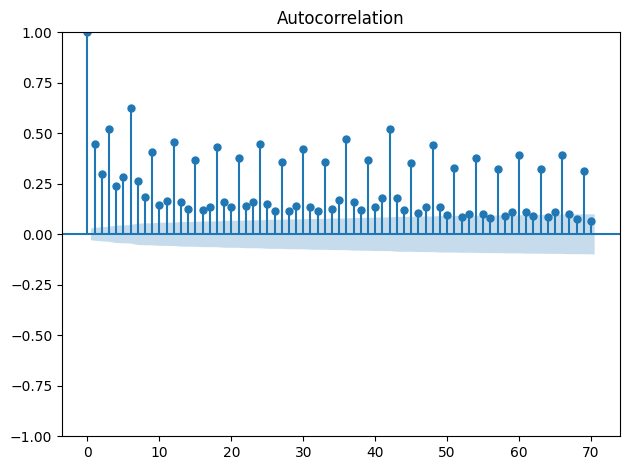

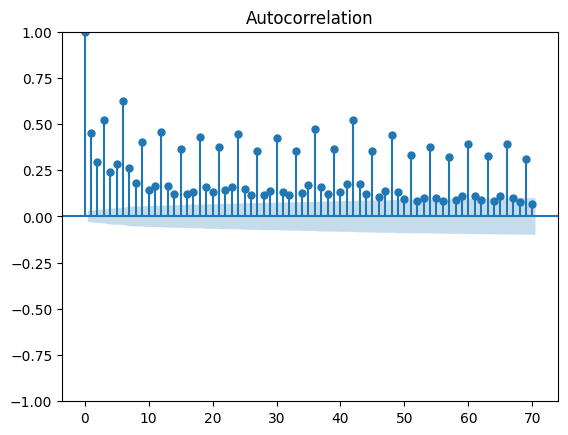

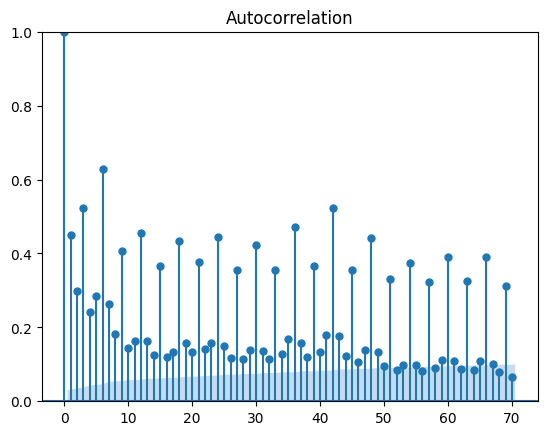

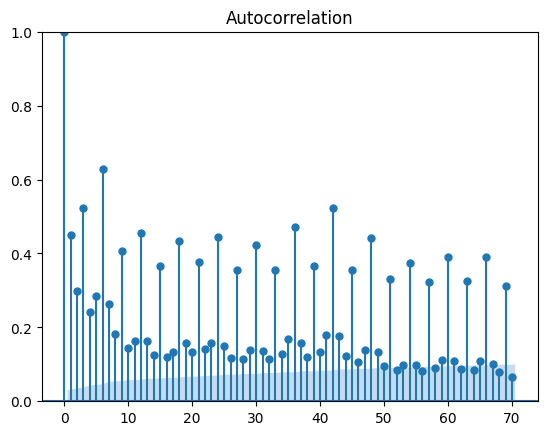

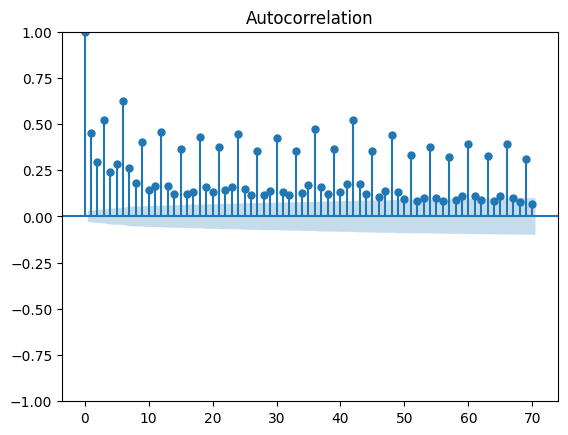

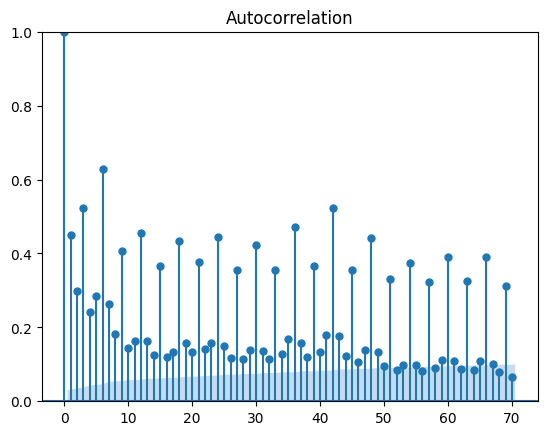

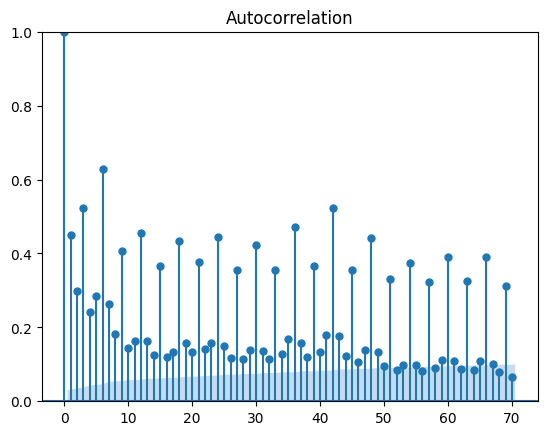

In [63]:
#to determine window wdith for forming sequences using autocorrelation
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt 
plot_acf(filtered_data_resampled_filled.loc['2016-01-01 01:00:00' :'2017-12-30 23:00:00'], lags= 70)
plt.ylim(0,1)
plt.show()
#high correlation after every 6 samples so every day

In [73]:
# Define the function to create the input and output sequences
def create_sequences(dataset, seq_length):
    X, y = [], []
    for i in range(len(dataset)-seq_length-1):
        seq = dataset.iloc[i:i+seq_length]
        X.append(seq)
        y.append(dataset.iloc[i+seq_length])
    return np.array(X), np.array(y)


In [74]:
#train test split 
#train on 2016 so as to validate on 2017
train_dataset_0= filtered_data_resampled_filled.loc['2016-01-01 00:00:00' :'2016-12-31 23:00:00']
test_dataset= filtered_data_resampled_filled.loc['2017-01-01 00:00:00' :'2017-12-31 23:00:00']

#then train on 2018 to perform inference on 2019
train_dataset_1= filtered_data_resampled_filled.loc['2018-01-01 00:00:00' :'2018-12-31 23:00:00']


seq_length= 6
X_train, y_train= create_sequences(train_dataset_0, seq_length)
X_test, y_test= create_sequences(test_dataset, seq_length)

In [81]:
#model definition

model=tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=128, input_shape=(seq_length, 1), return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.LSTM(units=64, return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.LSTM(units=64, return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.LSTM(units=64, return_sequences=False))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1, activation='relu'))

In [85]:
# Train the model
model.compile(loss=tf.losses.MeanSquaredError(), 
              optimizer=tf.optimizers.Adam(learning_rate=0.001),
              metrics=[tf.metrics.MeanAbsoluteError()])
model.fit(X_train, y_train, epochs=200, batch_size=16, verbose=2)

Epoch 1/200
137/137 - 21s - loss: 0.0223 - mean_absolute_error: 0.1117 - 21s/epoch - 152ms/step
Epoch 2/200
137/137 - 6s - loss: 0.0224 - mean_absolute_error: 0.1120 - 6s/epoch - 47ms/step
Epoch 3/200
137/137 - 7s - loss: 0.0220 - mean_absolute_error: 0.1109 - 7s/epoch - 54ms/step
Epoch 4/200
137/137 - 6s - loss: 0.0220 - mean_absolute_error: 0.1112 - 6s/epoch - 44ms/step
Epoch 5/200
137/137 - 7s - loss: 0.0217 - mean_absolute_error: 0.1101 - 7s/epoch - 54ms/step
Epoch 6/200
137/137 - 6s - loss: 0.0220 - mean_absolute_error: 0.1112 - 6s/epoch - 47ms/step
Epoch 7/200
137/137 - 4s - loss: 0.0215 - mean_absolute_error: 0.1100 - 4s/epoch - 32ms/step
Epoch 8/200
137/137 - 4s - loss: 0.0213 - mean_absolute_error: 0.1091 - 4s/epoch - 32ms/step
Epoch 9/200
137/137 - 4s - loss: 0.0213 - mean_absolute_error: 0.1088 - 4s/epoch - 28ms/step
Epoch 10/200
137/137 - 3s - loss: 0.0214 - mean_absolute_error: 0.1096 - 3s/epoch - 21ms/step
Epoch 11/200
137/137 - 3s - loss: 0.0214 - mean_absolute_error: 0.

In [127]:
def plot_prediction_sequence(predictions, target=None):
  import plotly.graph_objects as go
  fig = go.Figure()
  fig.add_trace(go.Scatter(y=predictions.flatten(), mode='lines', name='prediction'))
  if target is not None:
    fig.add_trace(go.Scatter(y=target.flatten(), mode='lines', name='target'))
  fig.show()

# do inference on 2017 data
predictions= model.predict(X_test)
plot_prediction_sequence(predictions, y_test)

69/69 [==============================] - 1s 15ms/step


In [96]:
# train on 2018 dataset
X_train2, y_train2= create_sequences(train_dataset_1, seq_length)
model.fit(X_train2, y_train2 ,epochs=200, batch_size=16, verbose=2)

Epoch 1/200
137/137 - 3s - loss: 0.0117 - mean_absolute_error: 0.0759 - 3s/epoch - 23ms/step
Epoch 2/200
137/137 - 3s - loss: 0.0103 - mean_absolute_error: 0.0720 - 3s/epoch - 22ms/step
Epoch 3/200
137/137 - 7s - loss: 0.0099 - mean_absolute_error: 0.0705 - 7s/epoch - 50ms/step
Epoch 4/200
137/137 - 3s - loss: 0.0097 - mean_absolute_error: 0.0701 - 3s/epoch - 25ms/step
Epoch 5/200
137/137 - 3s - loss: 0.0096 - mean_absolute_error: 0.0696 - 3s/epoch - 22ms/step
Epoch 6/200
137/137 - 4s - loss: 0.0096 - mean_absolute_error: 0.0693 - 4s/epoch - 28ms/step
Epoch 7/200
137/137 - 4s - loss: 0.0093 - mean_absolute_error: 0.0679 - 4s/epoch - 31ms/step
Epoch 8/200
137/137 - 4s - loss: 0.0092 - mean_absolute_error: 0.0687 - 4s/epoch - 29ms/step
Epoch 9/200
137/137 - 3s - loss: 0.0094 - mean_absolute_error: 0.0684 - 3s/epoch - 25ms/step
Epoch 10/200
137/137 - 3s - loss: 0.0090 - mean_absolute_error: 0.0676 - 3s/epoch - 26ms/step
Epoch 11/200
137/137 - 4s - loss: 0.0091 - mean_absolute_error: 0.067

In [129]:
!mkdir -p saved_models
model.save('saved_models/v1') 

In [124]:
def prediction_for_next_month(init_seq, num_days):
  if init_seq.ndim!=3:
    print("adding a dimension for batchsize")
    init_seq= init_seq[np.newaxis, :]
  sampling_freq= 4
  samples_per_day= int(24/sampling_freq)
  num_samples= num_days*samples_per_day 

  predictions=[]
  for i in range(num_samples):
    pred= model.predict(init_seq)
    predictions.append(pred.item())

    #process sequence
    init_seq= np.roll(init_seq, -1)
    init_seq[0, -1]=pred.item()
  return np.array(predictions)



In [126]:
init_seq= np.array(filtered_data_resampled_filled.iloc[-6:])
predictions= prediction_for_next_month(init_seq, 31)
plot_prediction_sequence(predictions)

adding a dimension for batchsize
1/1 [==============================] - 0s 40ms/step


In [ ]:
import tensorflow as tf 
feature_columns= []

nb_lats, nb_lon= 3,3 

min, max= location_data['lat'].min(), location_data['lat'].max()
boundaries= list(np.linspace(min, max, nb_lats))
lat= tf.feature_column.numeric_column('lat')
bucket_lat= tf.feature_column.bucketized_column(lat, boundaries=boundaries)

min, max= location_data['lon'].min(), location_data['lon'].max()
boundaries= list(np.linspace(min, max, nb_lon))
lat= tf.feature_column.numeric_column('lon')
bucket_lon= tf.feature_column.bucketized_column(lat, boundaries=boundaries)

bucket_point= tf.feature_column.crossed_column([bucket_lat, bucket_lon], hash_bucket_size=nb_lats*nb_lon)
bucket_point= tf.feature_column.indicator_column(bucket_point)
feature_columns.append(bucket_point)

CO_col= tf.feature_column.numeric_column('CO')
feature_columns.append(CO_col)

No_col= tf.feature_column.numeric_column('NO_2')
feature_columns.append(No_col)

O3_col= tf.feature_column.numeric_column('O_3')
feature_columns.append(O3_col)

NOx_col=tf.feature_column.numeric_column('NOx')
feature_columns.append(NOx_col)

SO_2_col=tf.feature_column.numeric_column('SO_2')
feature_columns.append(SO_2_col)

In [ ]:
feature_layer= tf.keras.layers.DenseFeatures(feature_columns)
print(feature_layer(data).numpy()[0:50])

[[5.500e-01 7.592e+01 1.046e+02 1.347e+01 6.950e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00]
 [3.600e-01 6.103e+01 6.656e+01 2.311e+01 5.960e+00 1.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [4.000e-01 7.264e+01 9.122e+01 1.704e+01 6.060e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00]
 [3.600e-01 6.815e+01 8.564e+01 2.358e+01 7.930e+00 1.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [1.800e-01 5.833e+01 6.477e+01 3.506e+01 6.220e+00 1.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [1.500e-01 6.085e+01 6.690e+01 2.739e+01 7.060e+00 0.000e+00 0.000e+00
  0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [2.300e-01 2.643e+01 3.062e+01 3.815e+01 5.690e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e

In [5]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive
